In [1]:
# import argparse

# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()

#Choose GRU or LSTM here

#rnn = "GRU"
rnn = "LSTM"

In [2]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt


import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm

# Import the single DOF finite difference model
from mlp_singledof_rnn import MLP, MLPProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State



/home/alinjar/simple_training_warm_start/RNN


In [3]:
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, theta_init, v_start, v_goal):
        # input
        self.inp = inp 
        self.theta_init = theta_init
        self.v_start = v_start
        self.v_goal = v_goal

    def __len__(self):
        return len(self.inp)    

    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        theta_init = self.theta_init[idx]
        v_start = self.v_start[idx]
        v_goal = self.v_goal[idx]

        return (torch.tensor(inp).float(),
                torch.tensor(theta_init).float(),
                torch.tensor(v_start).float(),
                torch.tensor(v_goal).float())

In [4]:
def sample_uniform_trajectories(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [5]:
#Parameters for MLP model

num_batch = 1000
num_dof=1
num_steps=50
timestep=0.05
v_max=1.0
a_max=2.0
j_max=5.0
p_max=180.0*np.pi/180.0 
theta_init=0.0
maxiter_projection = 5
nvar_single = num_steps
nvar = num_dof * nvar_single
theta_init_min=-np.pi
theta_init_max=np.pi

In [6]:
#calculating number of constraints
num_acc = num_steps - 1
num_jerk = num_acc - 1
num_pos = num_steps
num_vel_constraints = 2 * num_steps * num_dof
num_acc_constraints = 2 * num_acc * num_dof
num_jerk_constraints = 2 * num_jerk * num_dof
num_pos_constraints = 2 * num_pos * num_dof
num_total_constraints = (num_vel_constraints + num_acc_constraints + 
                            num_jerk_constraints + num_pos_constraints)




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

#### creating dataset

dataset_size = num_batch*20 #200000

theta_init, rng_theta_init = sample_uniform_trajectories(41, var_min= theta_init_min, var_max = theta_init_max, dataset_size=dataset_size, nvar=1)
#print("theta_init", theta_init.shape)
v_start, rng_v_start = sample_uniform_trajectories(40, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)
#print("v_start", v_start.shape)
v_goal, rng_v_goal = sample_uniform_trajectories(39, var_min =-1.0*v_max, var_max = 1.0*v_max, dataset_size=dataset_size, nvar=1)

#For training
xi_samples, rng = sample_uniform_trajectories(42, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

#For validation
xi_val, rng_val = sample_uniform_trajectories(43, var_min=-v_max, var_max=v_max ,dataset_size=dataset_size, nvar=nvar)

# xi_samples = torch.from_numpy(xi_samples)
# xi_val = torch.from_numpy(xi_val)

inp = np.hstack(( xi_samples, theta_init, v_start, v_goal))

inp_val = np.hstack(( xi_val, theta_init, v_start, v_goal))

Using cuda device


In [8]:
print("inp_mean", inp.mean())
print("inp_std", inp.std())

inp_mean -0.00017285970188430394
inp_std 0.6235914652792635


In [9]:
# Using PyTorch Dataloader
train_dataset = TrajDataset(inp, theta_init, v_start, v_goal)
val_dataset = TrajDataset(inp_val, theta_init, v_start, v_goal)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)


In [10]:

if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

##


Training with LSTM


In [11]:

enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints #( xi_samples- 0:nvar, lamda_smples- nvar:2*nvar)

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

In [12]:


model = MLPProjectionFilter(mlp=mlp,rnn_context=rnn_context, rnn_init = rnn_init, num_batch = num_batch,num_dof=num_dof,num_steps=num_steps,
							timestep=timestep,v_max=v_max,a_max=a_max,j_max=j_max,p_max=p_max, 
							maxiter_projection=maxiter_projection, rnn=rnn).to(device)

print(type(model))                            

<class 'mlp_singledof_rnn.MLPProjectionFilter'>


In [13]:
epochs = 100
#step, beta = 0, 1.0 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 1e-4, weight_decay=6e-5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1, verbose=True)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, theta_init, v_start, v_goal) in tqdm(train_loader):
        
        # Input and Output 
        inp = inp.to(device)
        theta_init = theta_init.to(device)
        v_start = v_start.to(device)
        v_goal = v_goal.to(device)
        
        xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
        accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp, theta_init, v_start, v_goal, rnn)

        xi_samples_inp = inp[:, :nvar]

        primal_loss, fixed_point_loss, projection_loss, loss = model.mlp_loss(accumulated_res_primal, 
                                                                              accumulated_res_fixed_point, xi_samples_inp, xi_projected)

        
        optimizer.zero_grad() #clears the gradients of the model parameters
        loss.backward() #computes the gradients of the model parameters
        
        
        # #Gradient Norm check
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)  # L2 norm
        #         total_norm += param_norm.item() ** 2

        # total_norm = total_norm ** 0.5
        # print(f"Gradient L2 norm: {total_norm:.4f}")
        
        ##Gradient Norm clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step() #updates the model parameters (e.g. weights and biases)
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        projection_losses.append(projection_loss.detach().cpu().numpy())
        
    if epoch % 2 == 0:
        
        # Validation 
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, theta_init, v_start, v_goal) in tqdm(val_loader):
                inp_val = inp_val.to(device)
                theta_init = theta_init.to(device)
                v_start = v_start.to(device)
                v_goal =  v_goal.to(device)

                xi_projected, accumulated_res_fixed_point, accumulated_res_primal, \
                accumulated_res_primal_temp, accumulated_res_fixed_point_temp = model(inp_val, theta_init, v_start, v_goal, rnn)

                xi_samples_inp_val = inp_val[:, :nvar]

                _, _, _, val_loss = model.mlp_loss(
                    accumulated_res_primal, accumulated_res_fixed_point, xi_samples_inp_val, xi_projected
                )

                val_losses.append(val_loss.detach().cpu().numpy())

                #print(f"Validation Loss: {np.average(val_losses):.4f}")
            

    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")
        print(f"Train Loss: {np.average(losses_train):.4f}")
        


    #step += 0.07 #0.15
    #scheduler.step()

    # mean_train_loss = np.mean(losses_train)
    # mean_val_loss = np.mean(val_losses)
    
    os.makedirs("./training_weights", exist_ok=True)
    #if mean_val_loss <= last_loss:
    if loss <= last_loss:
            torch.save(model.state_dict(), f"./training_weights/mlp_learned_single_dof_{rnn}.pth")
            last_loss = loss

    avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), \
    avg_projection_loss.append(np.average(projection_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses))
    avg_val_loss.append(np.average(val_losses))


100%|██████████| 20/20 [00:00<00:00, 74.45it/s]


Epoch: 1
Train Loss: 6.3684


100%|██████████| 20/20 [00:00<00:00, 73.54it/s]


Epoch: 3
Train Loss: 3.8341


100%|██████████| 20/20 [00:00<00:00, 57.13it/s]


Epoch: 5
Train Loss: 1.2056


100%|██████████| 20/20 [00:00<00:00, 73.53it/s]


Epoch: 7
Train Loss: 0.6743


100%|██████████| 20/20 [00:00<00:00, 70.67it/s]


Epoch: 9
Train Loss: 0.4455


100%|██████████| 20/20 [00:00<00:00, 72.75it/s]


Epoch: 11
Train Loss: 0.3625


100%|██████████| 20/20 [00:00<00:00, 72.75it/s]


Epoch: 13
Train Loss: 0.3327


100%|██████████| 20/20 [00:00<00:00, 73.72it/s]


Epoch: 15
Train Loss: 0.3159


100%|██████████| 20/20 [00:00<00:00, 73.86it/s]


Epoch: 17
Train Loss: 0.3028


100%|██████████| 20/20 [00:00<00:00, 71.89it/s]


Epoch: 19
Train Loss: 0.2940


100%|██████████| 20/20 [00:00<00:00, 58.12it/s]


Epoch: 21
Train Loss: 0.2865


100%|██████████| 20/20 [00:00<00:00, 73.23it/s]


Epoch: 23
Train Loss: 0.2797


100%|██████████| 20/20 [00:00<00:00, 74.45it/s]


Epoch: 25
Train Loss: 0.2745


100%|██████████| 20/20 [00:00<00:00, 58.17it/s]


Epoch: 27
Train Loss: 0.2700


100%|██████████| 20/20 [00:00<00:00, 74.55it/s]


Epoch: 29
Train Loss: 0.2665


100%|██████████| 20/20 [00:00<00:00, 74.26it/s]


Epoch: 31
Train Loss: 0.2721


100%|██████████| 20/20 [00:00<00:00, 74.26it/s]


Epoch: 33
Train Loss: 0.2667


100%|██████████| 20/20 [00:00<00:00, 73.39it/s]


Epoch: 35
Train Loss: 0.2634


100%|██████████| 20/20 [00:00<00:00, 72.53it/s]


Epoch: 37
Train Loss: 0.2601


100%|██████████| 20/20 [00:00<00:00, 73.49it/s]


Epoch: 39
Train Loss: 0.2574


100%|██████████| 20/20 [00:00<00:00, 74.26it/s]


Epoch: 41
Train Loss: 0.2592


100%|██████████| 20/20 [00:00<00:00, 57.76it/s]


Epoch: 43
Train Loss: 0.2546


100%|██████████| 20/20 [00:00<00:00, 74.89it/s]


Epoch: 45
Train Loss: 0.2533


100%|██████████| 20/20 [00:00<00:00, 71.99it/s]


Epoch: 47
Train Loss: 0.2500


100%|██████████| 20/20 [00:00<00:00, 58.37it/s]


Epoch: 49
Train Loss: 0.2488


100%|██████████| 20/20 [00:00<00:00, 74.07it/s]


Epoch: 51
Train Loss: 0.2498


100%|██████████| 20/20 [00:00<00:00, 73.24it/s]


Epoch: 53
Train Loss: 0.2453


100%|██████████| 20/20 [00:00<00:00, 73.06it/s]


Epoch: 55
Train Loss: 0.2447


100%|██████████| 20/20 [00:00<00:00, 69.36it/s]


Epoch: 57
Train Loss: 0.2452


100%|██████████| 20/20 [00:00<00:00, 68.45it/s]


Epoch: 59
Train Loss: 0.2440


100%|██████████| 20/20 [00:00<00:00, 71.05it/s]


Epoch: 61
Train Loss: 0.2414


100%|██████████| 20/20 [00:00<00:00, 72.83it/s]


Epoch: 63
Train Loss: 0.2437


100%|██████████| 20/20 [00:00<00:00, 57.31it/s]


Epoch: 65
Train Loss: 0.2464


100%|██████████| 20/20 [00:00<00:00, 73.88it/s]


Epoch: 67
Train Loss: 0.2430


100%|██████████| 20/20 [00:00<00:00, 73.56it/s]


Epoch: 69
Train Loss: 0.2395


100%|██████████| 20/20 [00:00<00:00, 57.30it/s]


Epoch: 71
Train Loss: 0.2475


100%|██████████| 20/20 [00:00<00:00, 72.82it/s]


Epoch: 73
Train Loss: 0.2464


100%|██████████| 20/20 [00:00<00:00, 75.13it/s]


Epoch: 75
Train Loss: 0.2447


100%|██████████| 20/20 [00:00<00:00, 56.61it/s]


Epoch: 77
Train Loss: 0.2405


100%|██████████| 20/20 [00:00<00:00, 73.20it/s]


Epoch: 79
Train Loss: 0.2391


100%|██████████| 20/20 [00:00<00:00, 72.31it/s]


Epoch: 81
Train Loss: 0.2383


100%|██████████| 20/20 [00:00<00:00, 73.60it/s]


Epoch: 83
Train Loss: 0.2364


100%|██████████| 20/20 [00:00<00:00, 73.05it/s]


Epoch: 85
Train Loss: 0.2341


100%|██████████| 20/20 [00:00<00:00, 56.32it/s]


Epoch: 87
Train Loss: 0.2354


100%|██████████| 20/20 [00:00<00:00, 72.76it/s]


Epoch: 89
Train Loss: 0.2330


100%|██████████| 20/20 [00:00<00:00, 72.65it/s]


Epoch: 91
Train Loss: 0.2432


100%|██████████| 20/20 [00:00<00:00, 57.59it/s]


Epoch: 93
Train Loss: 0.2336


100%|██████████| 20/20 [00:00<00:00, 72.86it/s]


Epoch: 95
Train Loss: 0.2340


100%|██████████| 20/20 [00:00<00:00, 70.01it/s]


Epoch: 97
Train Loss: 0.2375


100%|██████████| 20/20 [00:00<00:00, 57.58it/s]


Epoch: 99
Train Loss: 0.2359


100%|██████████| 20/20 [00:00<00:00, 49.54it/s]


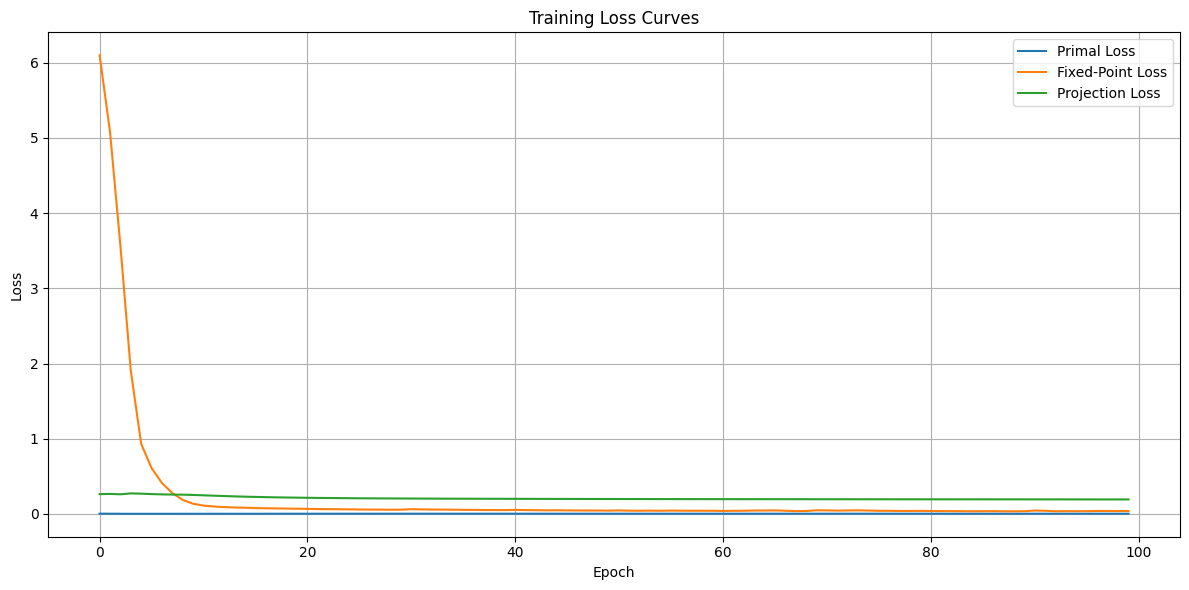

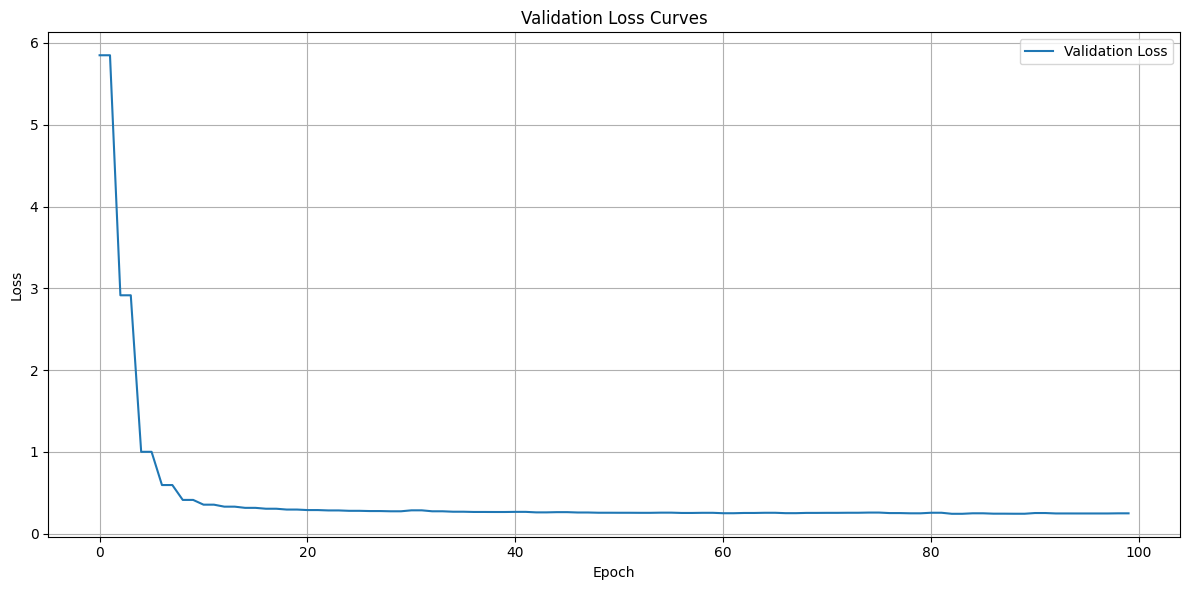

In [14]:
# Plot training losses

plt.figure(figsize=(12, 6))

#plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
avg_train_loss = np.asarray(avg_train_loss)
avg_val_loss = np.asarray(avg_val_loss)
print("Training_loss_end", avg_train_loss[-1])
print("Validation_loss_end", avg_val_loss[-1])

print("max projection_loss", np.max(np.asarray(avg_projection_loss)))
print("min projection_loss", np.min(np.asarray(avg_projection_loss)))

Training_loss_end 0.23623593
Validation_loss_end 0.24825124
max projection_loss 0.27382642
min projection_loss 0.19338167
